In [1]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('143B_SLC1A3_NAD-NADH_rotenone.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [4]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df_mean = df.groupby(['Aspartate', 'Rotenone']).mean().reset_index()
df_stdev = df.groupby(['Aspartate', 'Rotenone']).std().reset_index()

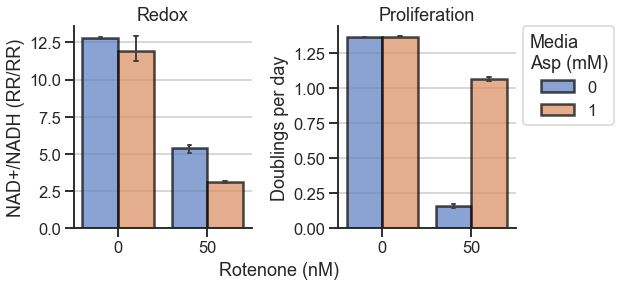

In [5]:
### Plot NAD/NADH ratio and proliferation rate ###

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1]})

g1 = sns.barplot(ax=ax1, data=df, x='Rotenone', y='NAD-NADH', hue='Aspartate', hue_order=[0, 1], ci=99, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g1.set_xlabel('')
g1.set_ylabel('NAD+/NADH (RR/RR)')
g1.set_title('Redox')
g1.grid(True, axis='y')
g1.legend_.remove()


g2 = sns.barplot(ax=ax2, data=df, x='Rotenone', y='Prlfr', hue='Aspartate', hue_order=[0, 1], ci=99, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7)
g2.set_xlabel('')
g2.set_ylabel('Doublings per day')
g2.set_title('Proliferation')
g2.grid(True, axis='y')
g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Media\nAsp (mM)')

sns.despine()
fig.text(0.45, 0, 'Rotenone (nM)', ha='center')
fig.tight_layout()


fig.savefig('plots/redox-prlfr_uncoupled_DUMMY-prlfr-data.pdf', bbox_inches='tight')